In [185]:
import albumentations as A
import os
from glob import glob
import pandas as pd
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('./data/train.csv')

In [4]:
label_df = pd.DataFrame(columns=['cat1','cat2','cat3','count'])
for n_cat1 in df['cat1'].unique() :
    cat2 = df[df['cat1'] == n_cat1]['cat2'].unique()
    for n_cat2 in cat2 :
        cat3  = df[df['cat1'] == n_cat1][df['cat2'] == n_cat2]['cat3'].unique()
        for n_cat3 in cat3 :
            cnt = len(df[df['cat1'] == n_cat1][df['cat2'] == n_cat2][df['cat3'] == n_cat3])
            n = pd.DataFrame([[n_cat1, n_cat2, n_cat3, cnt]], columns=['cat1', 'cat2', 'cat3', 'count'])
            label_df = pd.concat([label_df, n], ignore_index=True)

label_df

,cat1,cat2,cat3,count
0,자연,자연관광지,항구/포구,134
1,자연,자연관광지,섬,111
2,자연,자연관광지,자연휴양림,118
3,자연,자연관광지,해수욕장,207
4,자연,자연관광지,산,239
...,...,...,...,...
123,쇼핑,쇼핑,상설시장,270
124,쇼핑,쇼핑,"공예,공방",41
125,쇼핑,쇼핑,백화점,4
126,쇼핑,쇼핑,면세점,6


In [8]:
small_labels = label_df[label_df['count'] < 10]['cat3'].values
small_labels

array(['카지노', '번지점프', '카트', 'MTB', '인라인(실내 인라인 포함)', '사격장', 'ATV', '빙벽등반',
       '스키/스노보드', '스노쿨링/스킨스쿠버다이빙', '스카이다이빙', '헹글라이딩/패러글라이딩', '클럽',
       '외국문화원', '영화관', '학교', '전통공연', '대중콘서트', '연극', '뮤지컬', '클래식음악회',
       '이색체험', '분수', '터널', '발전소', '백화점', '면세점'], dtype=object)

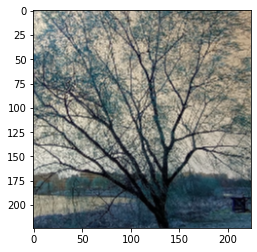

In [128]:
import random
import cv2
import matplotlib.pyplot as plt

transform = A.Compose([
    # H ,W = 1 : 1.5
    A.Resize(250, 375),
    A.OneOf([
        A.RandomCrop(224,224),
        A.CenterCrop(224,224)
    ], p=1),
    A.Blur(blur_limit=(2.2, 2.2), p=1)
    
])

img = cv2.imread('./data/image/train/TRAIN_00156.jpg')
plt.imshow(img)
img_ = transform(image=img)['image']
# img_.shape
plt.imshow(img_)


In [205]:
df = pd.read_csv('./data/train.csv')

transform = A.Compose([
    # H ,W = 1 : 1.5
    A.Resize(250, 375),
    A.OneOf([
        A.RandomCrop(224,224),
        A.CenterCrop(224,224)
    ], p=1),
    A.Blur(blur_limit=(2.2, 2.2), p=1)
])

root_path = './data/image/train'
for label in tqdm(small_labels) :
    img_names = df[df['cat3']==label]['id'].values
    
    # 10장 이상으로 맞춰주기
    aug_times = 10 // len(img_names) + 1
    for img_name in img_names :
        for t in range(aug_times) :
            img = cv2.imread(os.path.join(root_path, img_name+'.jpg'))
#             print(os.path.join(root_path, img_name+'.jpg'))
            img = transform(image=img)['image']
            
            new_name = f'aug_{str(t)}_'+img_name+'.jpg'
            cv2.imwrite(os.path.join(root_path, new_name), img)
    
            id = new_name.split('.')[0]
            img_path = os.path.join('./image/train', new_name)
            overview = df[df['id']== img_name]['overview'].values[0]
            cat1 = df[df['id']== img_name]['cat1'].values[0]
            cat2 = df[df['id']== img_name]['cat2'].values[0]
            cat3 = df[df['id']== img_name]['cat3'].values[0]
            
            df.loc[len(df)] = [id, img_path, overview, cat1, cat2, cat3]
        # csv에도 추가해주기
        
    

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.66it/s]


In [206]:
df.to_csv('./data/aug_train.csv', index=False)

In [207]:
df

,id,img_path,overview,cat1,cat2,cat3
0,TRAIN_00000,./image/train/TRAIN_00000.jpg,소안항은 조용한 섬으로 인근해안이 청정해역으로 일찍이 김 양식을 해서 높은 소득을 ...,자연,자연관광지,항구/포구
1,TRAIN_00001,./image/train/TRAIN_00001.jpg,경기도 이천시 모가면에 있는 골프장으로 대중제 18홀이다. 회원제로 개장을 했다가 ...,레포츠,육상 레포츠,골프
2,TRAIN_00002,./image/train/TRAIN_00002.jpg,금오산성숯불갈비는 한우고기만을 전문적으로 취급하고 사용하는 부식 자재 또한 유기농법...,음식,음식점,한식
3,TRAIN_00003,./image/train/TRAIN_00003.jpg,철판 위에서 요리하는 안동찜닭을 맛볼 수 있는 곳이다. 경상북도 안동시에 있는 한식...,음식,음식점,한식
4,TRAIN_00004,./image/train/TRAIN_00004.jpg,※ 영업시간 10:30 ~ 20:30\n\n3대에 걸쳐 아귀만을 전문으로 취급하는 ...,음식,음식점,한식
...,...,...,...,...,...,...
17340,aug_1_TRAIN_09131,./image/train\aug_1_TRAIN_09131.jpg,"1983년 대구공항 면세점이 창립하였으며, 21C 패션의 메카인 대구의 국제공항을 ...",쇼핑,쇼핑,면세점
17341,aug_0_TRAIN_11458,./image/train\aug_0_TRAIN_11458.jpg,대구 최초의 유일한 시내면세점으로 140여개의 최다 브랜드를 유치하여 신규 개장하는...,쇼핑,쇼핑,면세점
17342,aug_1_TRAIN_11458,./image/train\aug_1_TRAIN_11458.jpg,대구 최초의 유일한 시내면세점으로 140여개의 최다 브랜드를 유치하여 신규 개장하는...,쇼핑,쇼핑,면세점
17343,aug_0_TRAIN_11476,./image/train\aug_0_TRAIN_11476.jpg,"26년간 조선, 선박 기자재 수출 경험을 바탕으로 울산 시내 최초로 개점한 울산 진...",쇼핑,쇼핑,면세점


In [1]:
from torchvision import transforms


In [4]:
transform = transforms.Compose(
            [
                # transforms.RandomResizedCrop(image_size),
                transforms.Resize([250, 375]),
                transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                # add
                # transforms.RandAugment(),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )

from PIL import Image, ImageFile

img = transform(Image.open('./data/image/train/aug_0_TRAIN_00496.jpg').convert("RGB"))
img


tensor([[[ 0.5878,  0.5878,  0.5878,  ...,  0.5878,  0.5878,  0.5878],
         [ 0.5878,  0.5878,  0.5878,  ...,  0.5878,  0.5878,  0.5878],
         [ 0.5878,  0.5878,  0.5878,  ...,  0.5878,  0.5878,  0.5878],
         ...,
         [-0.7479, -0.7479, -0.7479,  ..., -0.3712, -0.3712, -0.3541],
         [-0.9534, -0.9363, -0.9192,  ..., -0.4226, -0.4054, -0.3712],
         [-1.1760, -1.1760, -1.1760,  ..., -0.4054, -0.4568, -0.5082]],

        [[ 0.7304,  0.7304,  0.7304,  ...,  0.7304,  0.7304,  0.7304],
         [ 0.7304,  0.7304,  0.7304,  ...,  0.7304,  0.7304,  0.7304],
         [ 0.7304,  0.7304,  0.7304,  ...,  0.7304,  0.7304,  0.7304],
         ...,
         [-0.4426, -0.4426, -0.4426,  ..., -0.2325, -0.2150, -0.2150],
         [-0.7227, -0.7227, -0.7052,  ..., -0.2850, -0.2500, -0.2325],
         [-0.9853, -0.9853, -1.0028,  ..., -0.2500, -0.3200, -0.3550]],

        [[ 0.9494,  0.9494,  0.9494,  ...,  0.9494,  0.9494,  0.9494],
         [ 0.9494,  0.9494,  0.9494,  ...,  0